<a href="https://colab.research.google.com/github/DrDourado/UofL_ME_613_ML_Course/blob/main/ME_613_04_Introduction_to_Obj_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook illustrates the basic concepts of convolutional neural networks (CNNs) applied to object detection. In it randomly generated images are used to demonstrate a object detection example through the concept of bounding boxes.

In this notebook, will walk through the creation of a neural network capable of predicting both image classification and bounding box coordinates. The training process incorporates the concept of Intersection over Union (IoU) to evaluate the accuracy of bounding box predictions. Steps demonstrated in this notebook includes:

1. **Synthetic Data Generation**: Synthetic data is generated to simplify the demonstration. This data includes images, labels (for image classification), and bounding boxes.
2. **Convolutional Neural Network (CNN) Architecture**: A simple functional CNN architecture is created using TensorFlow's Keras API. The architecture consists of convolutional layers followed by max-pooling layers and fully connected layers for image classification.
3. **Intersection over Union (IoU)**: The *`calculate_iou`* function computes the IoU between two bounding boxes. IoU is a measure of the overlap between two bounding boxes.
4. **Visualizing Bounding Boxes**: The *`visualize_bounding_boxes`* function visualizes images with their corresponding bounding boxes.
5. **Training the Model**: The model is trained using the generated synthetic data. The loss function used for the classification task is binary cross-entropy, and accuracy is used as the metric. For the regression problem related to obtaining the bounding boxes coordinates two different methods are illustrated, one using mean-squared error for the related regression problem, and another employing the IoU metric as the regression loss function.
6. **Visualizing Bounding Boxes After Training**: The trained models are used to make predictions on the validation set, and the predicted bounding boxes are visualized to assess the model's performance.

By going through this notebook, you should understand the basic workflow of building an object detection model using bounding box regression and how IoU is utilized in evaluating the model's performance.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate

In [2]:
# Generate synthetic data for demonstration
def generate_data(num_samples):
    images = np.random.rand(num_samples, 64, 64, 1)  # Generate random grayscale images
    labels = np.random.randint(2, size=num_samples)   # Generate random binary labels
    # bounding_boxes = np.random.randint(0, 32, size=(num_samples, 4))  # Generate random bounding boxes
    bounding_boxes = np.random.rand(num_samples, 4)*32 # Generate random bounding boxes
    return images, labels, bounding_boxes

In [3]:
# Create a CNN architecture for object detection
def create_model():
    # image_input = tf.keras.Input(shape=(64, 64, 3))
    image_input = tf.keras.Input(shape=(64, 64, 1))
    x1 = Conv2D(16, (3, 3), activation='relu')(image_input)
    x2 = MaxPooling2D((2, 2))(x1)
    x3 = Conv2D(32, (3, 3), activation='relu')(x2)
    x4 = MaxPooling2D((2, 2))(x3)
    x5 = Flatten()(x4)
    x6 = Dense(64, activation='relu')(x5)

    # Output layers for classification and bounding box regression
    class_output = Dense(1, activation='sigmoid', name='class_output')(x6)
    bbox_output = Dense(4, activation='linear', name='bbox_output')(x6)

    model = tf.keras.Model(inputs=image_input, outputs=[class_output, bbox_output])
    return model

def iou_model():
    # image_input = tf.keras.Input(shape=(64, 64, 3))
    image_input = tf.keras.Input(shape=(64, 64, 1))
    x1 = Conv2D(16, (3, 3), activation='relu')(image_input)
    x2 = MaxPooling2D((2, 2))(x1)
    x3 = Conv2D(32, (3, 3), activation='relu')(x2)
    x4 = MaxPooling2D((2, 2))(x3)
    x5 = Flatten()(x4)
    x6 = Dense(64, activation='relu')(x5)

    # Output layers for classification and bounding box regression
    class_output = Dense(1, activation='sigmoid', name='class_output')(x6)
    bbox_output = Dense(4, activation='linear', name='bbox_output')(x6)

    model = tf.keras.Model(inputs=image_input, outputs=bbox_output)
    return model

In [4]:
# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate intersection coordinates
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    # Calculate intersection area
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Calculate union area
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

In [5]:
# Intersection over Union (IoU) function
def tf_loss_iou(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)

    # # Reshape y_true to have shape (-1, 4) if necessary
    # y_true = tf.reshape(y_true, (-1, 4))

    # Extract coordinates of true and predicted bounding boxes
    true_x1, true_y1, true_w, true_h = tf.split(y_true, 4, axis=-1)
    pred_x1, pred_y1, pred_w, pred_h = tf.split(y_pred, 4, axis=-1)

    # Calculate coordinates of intersection rectangle
    x1 = tf.maximum(true_x1, pred_x1)
    y1 = tf.maximum(true_y1, pred_y1)
    x2 = tf.minimum(true_x1 + true_w, pred_x1 + pred_w)
    y2 = tf.minimum(true_y1 + true_h, pred_y1 + pred_h)

    # Calculate intersection area
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # Calculate area of true and predicted bounding boxes
    true_area = true_w * true_h
    pred_area = pred_w * pred_h

    # Calculate union area
    union = true_area + pred_area - intersection

    # Avoid division by zero
    epsilon = 1e-7

    # Calculate IoU
    iou = intersection / (union + epsilon)
    # return tf.reduce_mean(iou)
    return iou

In [6]:
# Custom loss function for bounding box regression using mse
def custom_loss_mse(y_true, y_pred):
    # Binary cross-entropy loss for classification
    class_loss = tf.keras.losses.binary_crossentropy(y_true[0], y_pred[0])

    # Mean squared error loss for bounding box regression
    bbox_loss = tf.keras.losses.mean_squared_error(y_true[1], y_pred[1])

    # Return combined loss
    return class_loss + bbox_loss

In [7]:
# Custom loss function for bounding box regression employing intercept over union (IoU)
# def custom_loss_iou(y_true, y_pred):
#     # Binary cross-entropy loss for classification
#     class_loss = tf.keras.losses.binary_crossentropy(y_true[0], y_pred[0])

#     # IoU loss for bounding box regression
#     iou_loss = 1 - tf_loss_iou(y_true[1], y_pred[1])

#     # Return combined loss
#     return class_loss + iou_loss

def custom_loss_iou(y_true, y_pred):
    # IoU loss for bounding box regression
    # iou_loss = 1 - tf_loss_iou(y_true, y_pred)
    iou_loss = - tf_loss_iou(y_true, y_pred)

    # Return combined loss
    return iou_loss

In [8]:
# Visualize bounding boxes
def visualize_bounding_boxes(images, bounding_boxes, predicted_boxes=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].reshape(64, 64), cmap='gray', alpha = 0.3)
        box = bounding_boxes[i]
        rect = plt.Rectangle((int(box[0]), int(box[1])), int(box[2]), int(box[3]), edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        if predicted_boxes is not None:
            pred_box = predicted_boxes[i]
            rect_pred = plt.Rectangle((int(pred_box[0]), int(pred_box[1])), int(pred_box[2]), int(pred_box[3]), edgecolor='g', facecolor='none')
            ax.add_patch(rect_pred)
        ax.axis('off')
    plt.show()

In [9]:
# Generate synthetic data
num_samples = 1000
images, labels, bounding_boxes = generate_data(num_samples)

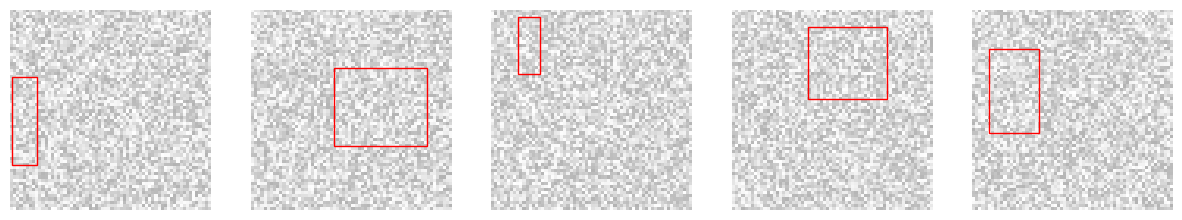

In [10]:
# Visualize synthetic data with bounding boxes
visualize_bounding_boxes(images[:5], bounding_boxes[:5])

In [11]:
# Split data into training and validation sets
train_images, val_images = images[:800], images[800:]
train_labels, val_labels = labels[:800], labels[800:]
train_boxes, val_boxes = bounding_boxes[:800], bounding_boxes[800:]

In [12]:
# Create and compile the model using mse
model_mse = create_model()
model_mse.compile(optimizer='adam', loss=custom_loss_mse)

In [13]:
# Train the model
history_mse = model_mse.fit(train_images, [train_labels, train_boxes], epochs=10, validation_data=(val_images, [val_labels, val_boxes]))

Epoch 1/10
25/25 [==============================] - 8s 178ms/step - loss: 148.6854 - class_output_loss: 3.2565 - bbox_output_loss: 145.4289 - val_loss: -114.1739 - val_class_output_loss: 6.6718 - val_bbox_output_loss: -120.8457
Epoch 2/10
25/25 [==============================] - 5s 187ms/step - loss: -124.7862 - class_output_loss: 1.6571 - bbox_output_loss: -126.4433 - val_loss: -162.7936 - val_class_output_loss: 0.7668 - val_bbox_output_loss: -163.5604
Epoch 3/10
25/25 [==============================] - 2s 95ms/step - loss: -120.8594 - class_output_loss: 1.0466 - bbox_output_loss: -121.9061 - val_loss: -157.2874 - val_class_output_loss: 0.7050 - val_bbox_output_loss: -157.9923
Epoch 4/10
25/25 [==============================] - 2s 81ms/step - loss: -134.7627 - class_output_loss: 1.0231 - bbox_output_loss: -135.7858 - val_loss: -143.8340 - val_class_output_loss: 1.6308 - val_bbox_output_loss: -145.4648
Epoch 5/10
25/25 [==============================] - 2s 80ms/step - loss: -119.2627 -

7/7 [==============================] - 0s 21ms/step


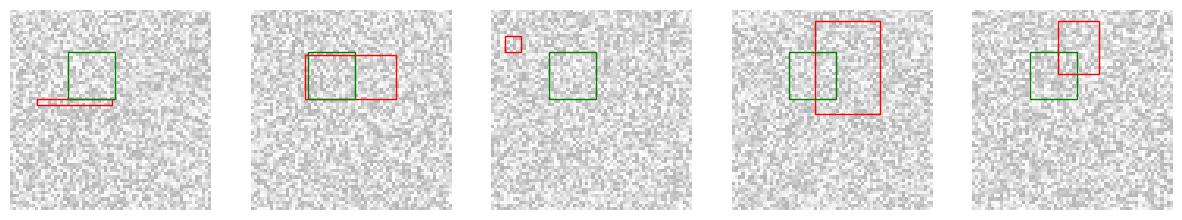

In [14]:
# Visualize bounding boxes after training
predictions_mse = model_mse.predict(val_images)
predicted_boxes_mse = np.round(predictions_mse[1]).astype(int)  # Scale predictions to match image dimensions
visualize_bounding_boxes(val_images[:5], val_boxes[:5], predicted_boxes_mse[:5])

In [15]:
calculate_iou(val_boxes[4], predicted_boxes_mse[4])

0.11647380259365424

In [16]:
calculate_iou(val_boxes[3], predicted_boxes_mse[3])

0.13480408511833347

In [17]:
# Create and compile the model with IoU loss
model_iou = iou_model()
model_iou.compile(optimizer='adam', loss=custom_loss_iou)

In [18]:
# Train the model
history_iou = model_iou.fit(train_images, train_boxes, epochs=10, validation_data=(val_images, val_boxes))

Epoch 1/10
25/25 [==============================] - 4s 110ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 2s 101ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 2s 80ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 2s 81ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
25/25 [==============================] - 2s 79ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
25/25 [==============================] - 3s 129ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
25/25 [==============================] - 2s 79ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
25/25 [==============================] - 2s 80ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
25/25 [==============================] - 2s 80ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
25/25 [===============

7/7 [==============================] - 0s 20ms/step


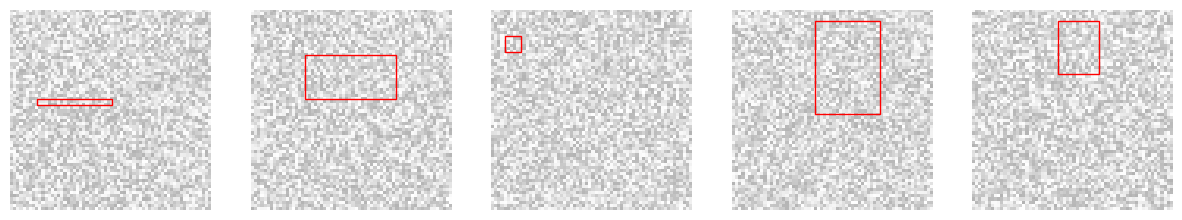

In [19]:
# Visualize bounding boxes after training with IoU
predictions_iou = model_iou.predict(val_images)
predicted_boxes_iou = np.round(predictions_iou).astype(int)  # Scale predictions to match image dimensions
visualize_bounding_boxes(val_images[:5], val_boxes[:5], predicted_boxes_iou[:5])